# Introduction to Laser Learning Environment

## 1. How to install
Enter the following instructions in a terminal:

- `pip install laser-learning-environment`
- `pip install rust`
- `pip install matplotlib`
- `pip install "git+https://github.com/yamoling/rlenv.git"`

This installs and compile the Laser Learning Environment and its dependencies, in the `lle` folder. Move this notebook to this folder, and restart jupyter. After this operation, you should be able to import `lle` in this notebook: 

In [1]:
import lle

If it works, you are ready to go !

In order to display the environment, we will use some functions from the package `matplotlib`. Some other available examples use the package `cv2`. Change the variable $display$ to $False$ if you do not want this notebook to display the boards.

In [2]:
import matplotlib.pyplot as plt
DISPLAY = True

## 2. Create a board
LLE works with files that define the environment. The cases are represented with characters in a quite intuitive manner, that allows to easily create a new board.

### 2.1 A simple empty board
Let us define a $6\times 5$ board with one agent and one destination.

In [3]:
def get_empty_board(x, y):
    return [["." for _ in range(x)] for _ in range(y)]

def get_board_as_str(board):
    return "\n".join([" ".join(i) for i in board])

def save_board(board, filename):
    """Saves a board to a file in order to reload it later"""
    f = open("./boards/"+filename, "w")
    f.write(get_board_as_str(board))
    f.close()
    
empty_board = get_empty_board(6, 5)
empty_board[0][0] = "S0"
empty_board[4][5] = "X"
save_board(empty_board, "empty")

This has created a file called `empty`. Check its content if the code was unclear.

We can now create a `World` object from this board:

In [4]:
from lle import World

def load_world(filename):
    return lle.World.from_file("./boards/"+filename)
empty = load_world("empty")

And directly display it using `matplotlib.pyplot.imshow()`:

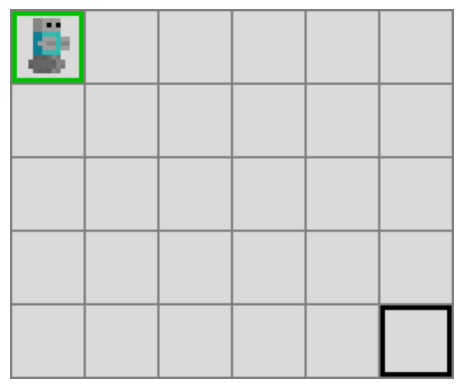

In [5]:
def display_world(w):
    if DISPLAY:
        plt.imshow(w.get_image())
        plt.axis('off')
        plt.show()

display_world(empty)

### 2.2 Some more complex boards
We can use other characters, such as:
- `@` for an obstacle
- `G` for a gem
- `V` for a void

And, as previously, use
- `X` for a destination
- `Sa`, with `a` being a number, corresponding to each agent

For example, with walls and voids:

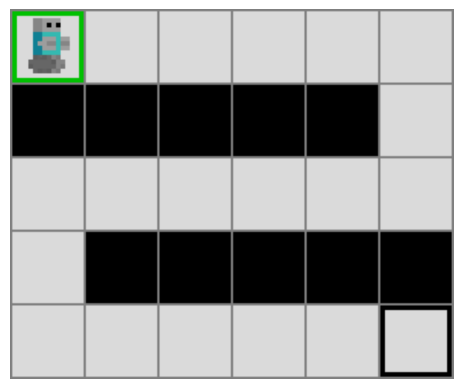

In [6]:
board_with_walls = get_empty_board(6, 5)
board_with_walls[0][0] = "S0"
board_with_walls[4][5] = "X"
board_with_walls[1] = ["@", "@", "@", "@", "@", "."]
board_with_walls[3] = [".", "V", "V", "V", "V", "V"]
save_board(board_with_walls, "walls")
with_walls = load_world("walls")
display_world(with_walls)

Or with gems

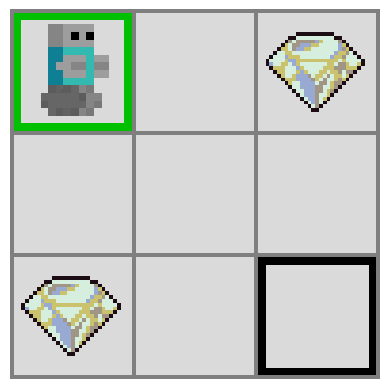

In [7]:
board_with_gems = get_empty_board(3, 3)
board_with_gems[0][0] = "S0"
board_with_gems[2][2] = "X"
board_with_gems[2][0] = "G"
board_with_gems[0][2] = "G"
save_board(board_with_gems, "gems")
with_gems = load_world("gems")
display_world(with_gems)

Or, finally, with multple agens:

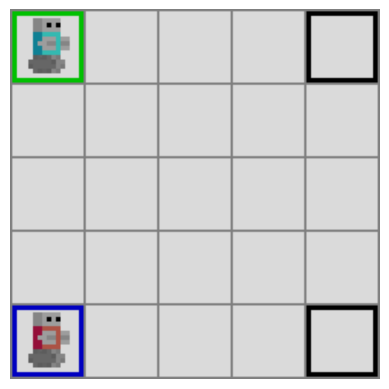

In [8]:
two_agents = get_empty_board(5, 5)
two_agents[0][0] = "S0"
two_agents[4][0] = "S1"
two_agents[4][4] = "X"
two_agents[0][4] = "X"
save_board(two_agents, "two_agents")
world_two_agents = load_world("two_agents")
display_world(world_two_agents)

### 2.3 Playing with lasers
Lasers of a certain colors prevent agents of another color to pass. They can be blocked by agents of the same color. They form the basis of the constaints in the `LLE` framework.

Lasers have two characteristics:
- A number, which denotes the color of the laser
- An orientation (North, South, West, East)

As an example, a laser with color $0$ pointing to $East$ will be noted `L0E`.
Here is an example of a two-agents-two-lasers game.

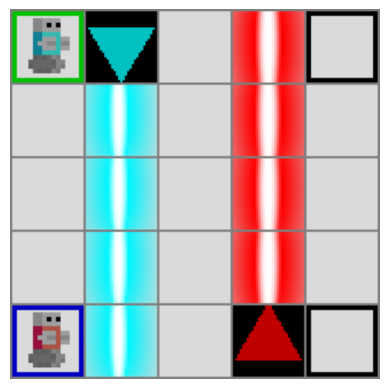

In [9]:
tatl = get_empty_board(5, 5)
tatl[0][0] = "S0"
tatl[4][0] = "S1"
tatl[4][4] = "X"
tatl[0][4] = "X"
tatl[0][1] = "L0S"
tatl[4][3] = "L1N"
save_board(tatl, "tatl")
world_tatl = load_world("tatl")
display_world(world_tatl)

### 2.4 Conclusion and final examples
From now on, you should be familiar with the notion of board, agent, laser, gems, and wall. You should be able to create and display complex boards to represent complex problems.

Remember: the whole point of this environment is to make the agents reach the targets, without passing through lasers of the wrong colors, and to collect as many gems as possible, in a minimum amount of time.

This set-up describes a coordination problem.

For the coming sections, we will work on different boards. A first simple linear one:

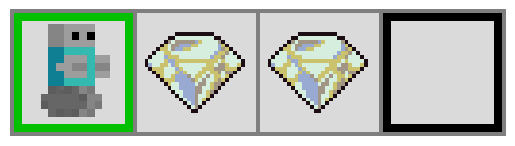

In [10]:
save_board([["S0", "G", "G", "X"]], "linear")
linear = load_world("linear")
display_world(linear)

Then, a simple two-agents example:

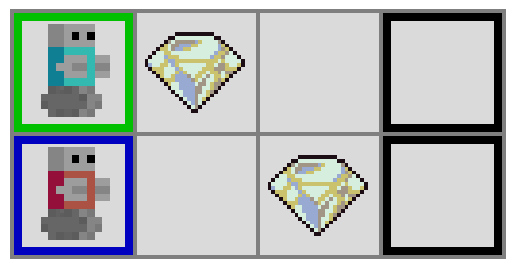

In [11]:
save_board([["S0", "G", ".", "X"], ["S1", ".", "G", "X"]], "linear2")
linear2 = load_world("linear2")
display_world(linear2)

And finally a more complex example:

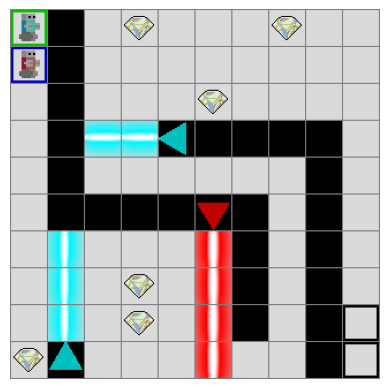

In [12]:
board =[
    ["S0", "@", ".", "G", ".", ".", ".", "G", ".", "."],
    ["S1", "@", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", "@", ".", ".", ".", "G", ".", ".", ".", "."],
    [".", "@", ".", ".", "L0W", "@", "@", "@", "@", "."],
    [".", "@", ".", ".", ".", ".", ".", ".", "V", "."],
    [".", "@", "@", "@", "@", "L1S", "@", ".", "V", "."],
    [".", ".", ".", ".", ".", ".", "@", ".", "V", "."],
    [".", ".", ".", "G", ".", ".", "@", ".", "V", "."],
    [".", ".", ".", "G", ".", ".", "@", ".", "V", "X"],
    ["G", "L0N", ".", ".", ".", ".", ".", ".", "V", "X"]
]
save_board(board, "board")
world = load_world("board")
display_world(world)

## 3 Playing with agents
### 3.1 Moving agents
To solve `LLE` problems, we have to move the agents across the board.
This can be done using `Action` objects, which can be either North, South, East, West, or STAY.

In [13]:
from lle import Action

For example, we can apply two times the action `EAST` on the first agent in the simple linear case to complete the problem. First, we `reset` the world, then we apply the function `step`. It takes a `list` as parameter, with as many `Actions` as there are agents to move. It returns the reward that was earned up at this move (not the total one).

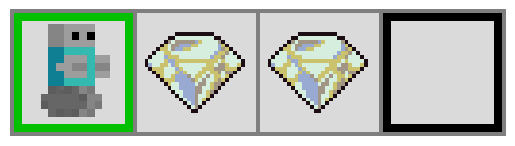

In [14]:
linear.reset()
display_world(linear)

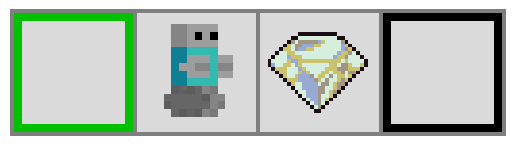

Reward: 1.0


In [15]:
reward = linear.step([Action.EAST])
display_world(linear)
print("Reward:", reward)

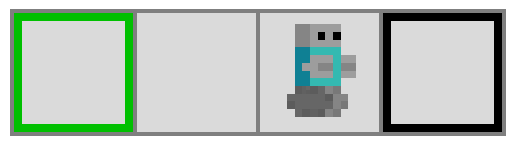

Reward: 1.0


In [16]:
reward = linear.step([Action.EAST])
display_world(linear)
print("Reward:", reward)

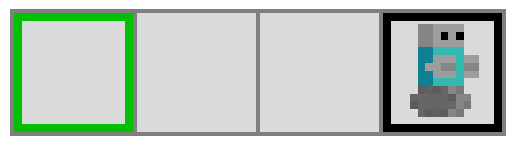

Reward (note that arriving in an exit gives a reward of 2): 2.0


In [17]:
reward = linear.step([Action.EAST])
display_world(linear)
print("Reward (note that arriving in an exit gives a reward of 1 and and a another reward is given for ending the game):", reward)

An agent that has reached an exit cannot move anymore. A world is done if all the agents have reached an exit (no matter the number of remaining gems). The attribute `done` allows to check if the world has reached a final state. When a world is done, no further step can be applied.

In [18]:
print(linear.done)

True


### 3.2 Getting information about the environment

Some attributes of the world allow to get more information about the problem setting. We show some of them on this more complex example:

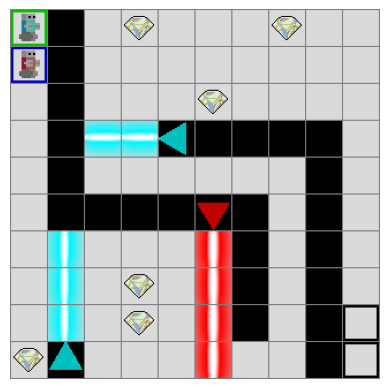

In [19]:
world.reset()
display_world(world)

In [26]:
world.reset()
print("Current state:", world.get_state())
print("Number of gems:", world.n_gems)
print("Number of collected gems:", world.gems_collected)
print("Position of the walls:", world.wall_pos)
print("Position of the voids:", world.void_pos)
print("Position of the exits:", world.exit_pos)
print("Position of the lasers:", world.lasers)
print("Position of the agents:", world.agents_positions)

Current state: WorldState(agent_positions=[(0, 0), (1, 0)], gems_collected=[false, false, false, false, false, false])
Number of gems: 6
Number of collected gems: 0
Position of the walls: [(0, 1), (1, 1), (2, 1), (3, 1), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 1), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 6), (7, 6), (8, 6), (9, 1)]
Position of the voids: [(4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8)]
Position of the exits: [(8, 9), (9, 9)]
Position of the lasers: [((3, 3), <builtins.Laser object at 0x145f340b0>), ((3, 2), <builtins.Laser object at 0x145e44430>), ((6, 5), <builtins.Laser object at 0x145e451b0>), ((7, 5), <builtins.Laser object at 0x145e46170>), ((8, 5), <builtins.Laser object at 0x145e46930>), ((9, 5), <builtins.Laser object at 0x145e46ff0>), ((8, 1), <builtins.Laser object at 0x145e44bb0>), ((7, 1), <builtins.Laser object at 0x145f1b470>), ((6, 1), <builtins.Laser object at 0x145f19570>)]
Position of the agents: [(0, 0), (1, 0)]


An important method is the `available_actions` one, which gives the possible actions for each of the agents:

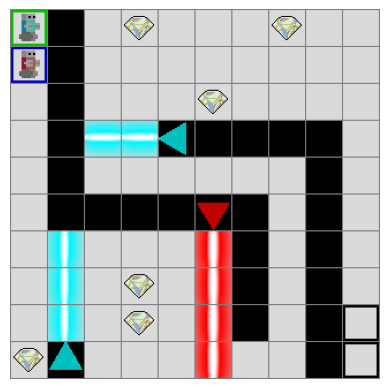

Available actions: [[Stay], [Stay, South]]


In [21]:
display_world(world)
print("Available actions:", world.available_actions())

See how those actions change when we make a step:

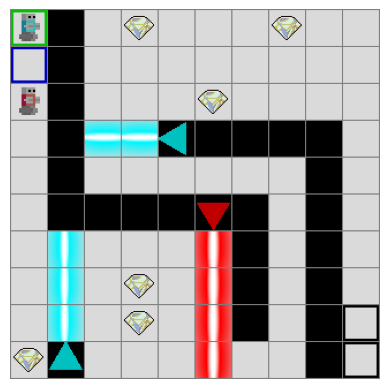

Available actions: [[Stay, South], [Stay, North, South]]


In [22]:
world.step([Action.STAY, Action.SOUTH])
display_world(world)
print("Available actions:", world.available_actions())

But see how some actions are not combinable: if we ask for two agents to reach the same tile, they do not move, and the reward is $0$.

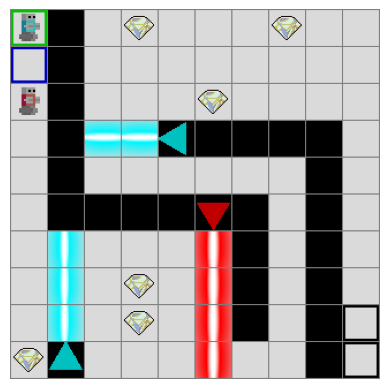

In [23]:
world.step([Action.SOUTH, Action.NORTH])
display_world(world)

## 4. Conclusion
In this notebook, we have seen how to design a `lle` problem, and we have shown how to interact with agents. We have defined the problem of solving such defined environments.

Most of the functions that we have defined here are available in the file `utils.py`. They will be used in further tutorials.